In [1]:
import wkbl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import nbody_essentials as nbe
from matplotlib.patches import Circle

In [2]:
# path to RAMSES snapshot
path = "/data/OWN/Adicora/output_00041"
# load simulation
myhalo = wkbl.Galaxy_Hound(path)
# calculate center with stars
center = nbe.real_center(myhalo.st.pos3d, myhalo.st.mass)
print("center--> [x y z] =",center," [kpc]")
# recenter the whole thing
myhalo.center_shift(center)
# computes virial radii and cuts data with r>n*rvir
myhalo.r_virial(r_max=400,n=2.5)
print("r200 = {0:.2f} kpc".format(myhalo.r200))

loading Dark matter..
loading Stars..
loading Gas..
center--> [x y z] = [14314.92184042 15227.63864653 15696.15744377]  [kpc]
| Diagonal matrix computed 
|    | 19, 0, 0|
| D =| 0, 15, 0|
|    | 0,  0, 4|
r200 = 210.68 kpc


to calculate the density at the position o each particle it is necesary to load the cfalcon module of unsiotools

In [3]:
import unsiotools.simulations.cfalcon as falcon
cf=falcon.CFalcon()

then the dark matter density can be computed as

In [4]:
pos = np.array(myhalo.dm.pos3d.reshape(len(myhalo.dm.pos3d)*3),dtype=np.float32)
mass = np.array(myhalo.dm.mass,dtype=np.float32)
ok,myhalo.dm.rho,_=cf.getDensity(pos,mass)


# DM distribution

112
7849058.977274572 13290257413.0


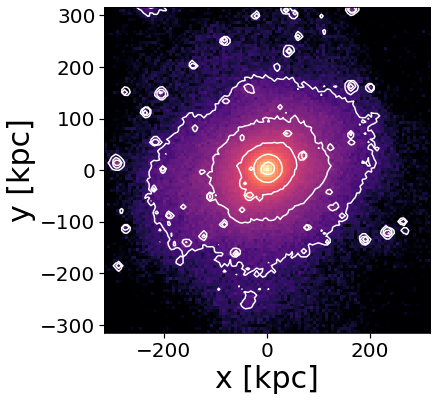

In [20]:
thickness=200
pixels = int(3*myhalo.r200/myhalo.p.reslim/20)
print(pixels)
edges = np.linspace(-1.5*myhalo.r200,1.5*myhalo.r200,pixels)
x,y,z=0,1,2
zfil = np.where(np.abs(myhalo.dm.pos3d[:,2])<thickness)[0]
H, xedges, yedges = np.histogram2d(myhalo.dm.pos3d[zfil,x], 
                                   myhalo.dm.pos3d[zfil,y],
                                   bins=(edges, edges),
                                   weights=myhalo.dm.mass[zfil])
fullbox = H.T
a,b = np.mean(fullbox)*0.1, np.max(fullbox)
print(a, b)

fig, ax =plt.subplots(figsize=[6,6])
mass_2 = ax.imshow(fullbox+0.1,interpolation='nearest', origin='low',cmap="magma",
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                       norm=LogNorm(vmin=a,vmax=b)
                  )
ax.set_xlabel("x [kpc]",fontsize=30)
ax.set_ylabel("y [kpc]",fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20, size=5,width=1.2)




edges = np.linspace(-1.5*myhalo.r200,1.5*myhalo.r200,pixels)

zfil = np.where(np.abs(myhalo.dm.pos3d[:,2])<thickness)[0]
H, xedges, yedges = np.histogram2d(myhalo.dm.pos3d[zfil,x], 
                                   myhalo.dm.pos3d[zfil,y],
                                   bins=(edges, edges),
                                   weights=myhalo.dm.rho[zfil])
X, Y = np.meshgrid(edges[1:], edges[1:])
Z = H.T
CS = ax.contour(X, Y, Z,np.logspace(5,10,5),colors='w')

Using the Profile class in `nbe` an profile object is created that contains information about the DM-profile. The initialization of this objects takes as input the simulation object, and the resolution limit.


In [55]:
myhalo.profile = nbe.Profile(myhalo,myhalo.p.reslim)

inside this object:

- r, profile: the DM density profile computed spherically and the correspondent radius.
- r, mean: mean density per radial bin, equivalent to the profile array for the region without substructure.
- r, std: the standard deviation on the density in each radial bin.
- r, cummass: the cumulative mass
- r, n_dm_bin: the number of dm particles per bin

all this arrays start from 3 times the resolution limit outward, information is available for the inner part aswell: r_in, profile_in


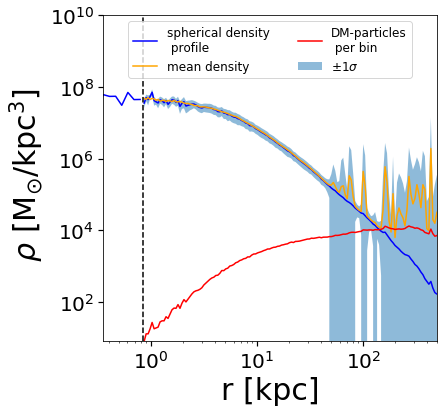

In [60]:
fig, ax =plt.subplots(figsize=[6,6])
ax.set_ylim([myhalo.profile.n_dm_bin.min(),
             1e10])
ax.set_xlim([0.35,5e2])

ax.loglog()
ax.fill_between(myhalo.profile.r,myhalo.profile.profile+myhalo.profile.std,
                myhalo.profile.profile-myhalo.profile.std,alpha=0.5,label="$\pm 1 \sigma$"
               )
ax.plot(myhalo.profile.r,myhalo.profile.profile,c='b',
        label="spherical density \n profile")
ax.plot(myhalo.profile.r_in,myhalo.profile.profile_in,color="b")
ax.plot(myhalo.profile.r,myhalo.profile.mean,color="orange",
        label="mean density")


ax.plot(myhalo.profile.r,myhalo.profile.n_dm_bin,c='r',
        label="DM-particles\n per bin")
ax.axvline(x=3*myhalo.p.reslim,linestyle='--',color='k')


legend = ax.legend(loc='upper center', ncol=2, shadow=False, fontsize=12)
ax.set_xlabel("r [kpc]",fontsize=30)
ax.set_ylabel(r" $\rho$ [M$_{\odot}$/kpc$^3$]",fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20, size=5,width=1.2)


In [58]:
r = np.logspace(np.log10(0.5),np.log10(2*myhalo.r200),300)
M_dm = np.array([nbe.m_matrix_for_r(myhalo,'halo',i)[0] for i in r])
a_dm, b_dm, c_dm = np.sqrt(M_dm[:,0,0]), np.sqrt(M_dm[:,1,1]), np.sqrt(M_dm[:,2,2])
S_dm = c_dm/a_dm
T_dm = ((a_dm**2) - (b_dm**2))/((a_dm**2) -(c_dm**2)) 


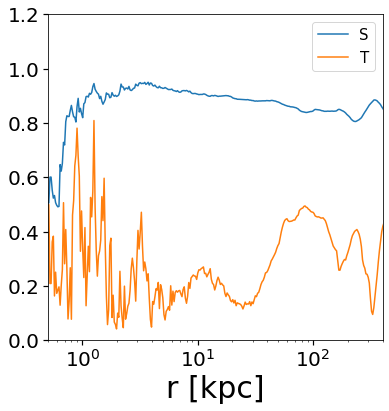

In [59]:
fig, ax = plt.subplots(figsize=[6,6])
ax.set_xlim([0.5,400])
ax.set_ylim([0.,1.2])
ax.set_xscale("log")
ax.plot(r, S_dm,label="S")
ax.plot(r, T_dm,label="T")

ax.set_xlabel("r [kpc]",fontsize=30)
#ax.set_ylabel(" [kpc]",fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20, size=5,width=1.2)
legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=15)
